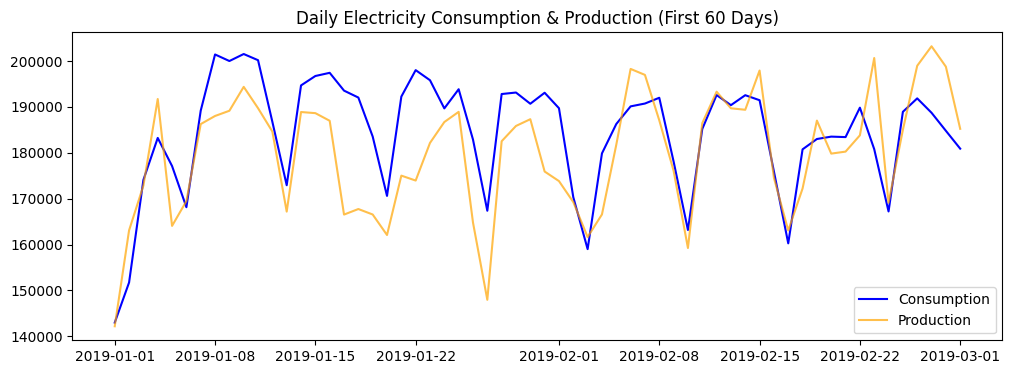

In [23]:
# ========================================================
# 1️⃣ DATA LOADING, EDA, & FEATURE ENGINEERING
# ========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import os
from statsmodels.tsa.stattools import adfuller

# --- PATH CORRECTION ---
OUTPUT_FOLDER = "../outputs"
PROCESSED_DATA_FOLDER = "../data/processed"
RAW_DATA_PATH = "../data/raw/electricity.csv"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(PROCESSED_DATA_FOLDER, exist_ok=True)

# 1. Load Dataset
df = pd.read_csv(RAW_DATA_PATH)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# 2. Missing Values & Duplicates
df = df.drop_duplicates()
df = df.ffill() 

# --------------------------------------------------------
# 📊 Exploratory Data Analysis (EDA) - PLOTS
# --------------------------------------------------------
# [Keeping your plotting code exactly as is, it's perfect for the report]
df_daily = df.resample('D').sum()
df['DayOfWeek_Str'] = df.index.day_name() # Renamed to avoid confusion with numeric DayOfWeek
avg_by_day = df.groupby('DayOfWeek_Str')['Consumption'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

# Plot 1: Daily trends
plt.figure(figsize=(12,4))
plt.plot(df_daily['Consumption'].iloc[:60], label='Consumption', color='blue')
plt.plot(df_daily['Production'].iloc[:60], label='Production', color='orange', alpha=0.7)
plt.title('Daily Electricity Consumption & Production (First 60 Days)')
plt.legend()
plt.savefig(f'{OUTPUT_FOLDER}/01_daily_trends_60d.png', dpi=300)
plt.show()

# --------------------------------------------------------
# ⚙️ Feature Engineering
# --------------------------------------------------------

# 1. Use lags that are at least 24 hours old
df['lag_24'] = df['Consumption'].shift(24)
df['lag_48'] = df['Consumption'].shift(48)
df['lag_168'] = df['Consumption'].shift(168) 

# 2. Rolling Averages (Shifted by 24h to avoid leakage)
df['rolling_24h'] = df['Consumption'].shift(24).rolling(window=24).mean()
df['rolling_7d'] = df['Consumption'].shift(24).rolling(window=168).mean()

# 3. Production Features
df['prod_lag_24'] = df['Production'].shift(24)

# 4. Time-Based Features (Extracted from DateTime Index)
df['hour'] = df.index.hour
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

# Cyclic Transformations
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 5. Seasonal Features
def assign_season(month):
    if month in [12,1,2]: return 'winter'
    elif month in [3,4,5]: return 'spring'
    elif month in [6,7,8]: return 'summer'
    else: return 'fall'

df['season'] = df['month'].map(assign_season)
df = pd.get_dummies(df, columns=['season'], drop_first=True)

# Convert dummies to int
for col in df.columns:
    if 'season_' in col:
        df[col] = df[col].astype(int)

# 6. Create 24-Hour Multi-Output Targets
for h in range(1, 25):
    df[f'target_{h}'] = df['Consumption'].shift(-h)

# 7. Final Cleanup for Modeling
df_model = df.dropna().copy()
df_model = df_model.select_dtypes(include=[np.number])

# Define X and y
target_cols = [f'target_{h}' for h in range(1, 25)]
X = df_model.drop(columns=target_cols)
y = df_model[target_cols]

In [24]:
# =========================
# 1️⃣ Linear Regression (Baseline)
# =========================

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Use the pre-defined X and y from Block 1
X_lr = X.copy()
y_lr = y.copy()

# 2. Time Series Cross-Validation (5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize model
lr_model = LinearRegression()

# Store metrics
rmse_scores = []
mae_scores = []
r2_scores = []

print("Starting Linear Regression CV...")

# 3. The Loop (Fold printing removed for cleanliness)
for train_idx, test_idx in tscv.split(X_lr):
    X_train, X_test = X_lr.iloc[train_idx], X_lr.iloc[test_idx]
    y_train, y_test = y_lr.iloc[train_idx], y_lr.iloc[test_idx]
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train & Predict
    lr_model.fit(X_train_scaled, y_train)
    y_pred = lr_model.predict(X_test_scaled)
    
    # Metrics
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

# 4. Final Average Results (Standardized Dashboard Style)
final_lr_rmse = np.mean(rmse_scores)

print("\n" + "="*35)
print("📈 LINEAR REGRESSION FINAL RESULTS")
print("="*35)
print(f"Average RMSE: {final_lr_rmse:.2f}")
print(f"Average MAE:  {np.mean(mae_scores):.2f}")
print(f"Average R²:   {np.mean(r2_scores):.3f}")
print("="*35)


Starting Linear Regression CV...

📈 LINEAR REGRESSION FINAL RESULTS
Average RMSE: 537.52
Average MAE:  411.80
Average R²:   0.706


In [25]:
# =========================
# 2️⃣ k-NN Regression with Scaling and Hyperparameter Search
# =========================

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import itertools

# Updated for Multi-Output
X_knn = X.copy()
y_knn = y.copy()

# Hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

best_rmse_knn = np.inf
best_params_knn = {}
final_mae_knn = 0
final_r2_knn = 0

print("Starting k-NN Grid Search...")

# Time Series Cross-Validation with scaling
for n, w, p in itertools.product(param_grid['n_neighbors'], 
                                 param_grid['weights'], 
                                 param_grid['p']):
    
    fold_rmse = []
    fold_mae = []
    fold_r2 = []
    
    for train_idx, test_idx in tscv.split(X_knn):
        X_train, X_test = X_knn.iloc[train_idx], X_knn.iloc[test_idx]
        y_train, y_test = y_knn.iloc[train_idx], y_knn.iloc[test_idx]
        
        # Scale numeric features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit k-NN model
        knn_model = KNeighborsRegressor(n_neighbors=n, weights=w, p=p)
        knn_model.fit(X_train_scaled, y_train)
        y_pred = knn_model.predict(X_test_scaled)
        
        fold_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        fold_mae.append(mean_absolute_error(y_test, y_pred))
        fold_r2.append(r2_score(y_test, y_pred))
    
    avg_rmse = np.mean(fold_rmse)
    
    if avg_rmse < best_rmse_knn:
        best_rmse_knn = avg_rmse
        best_params_knn = {'n_neighbors': n, 'weights': w, 'p': p}
        final_mae_knn = np.mean(fold_mae)
        final_r2_knn = np.mean(fold_r2)

# Final Average Results (Standardized Dashboard Style)
print(f"\n✅ Best k-NN Configuration: {best_params_knn}")

print("\n" + "="*35)
print("📈 k-NN FINAL RESULTS")
print("="*35)
print(f"Average RMSE: {best_rmse_knn:.2f}")
print(f"Average MAE:  {final_mae_knn:.2f}")
print(f"Average R²:   {final_r2_knn:.3f}")
print("="*35)


Starting k-NN Grid Search...

✅ Best k-NN Configuration: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}

📈 k-NN FINAL RESULTS
Average RMSE: 504.96
Average MAE:  370.64
Average R²:   0.730


In [26]:
# =========================
# 3️⃣ Random Forest Regressor with Hyperparameter Tuning
# =========================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import numpy as np

# Updated for Multi-Output
X_rf = X.copy()
y_rf = y.copy()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2']
}

best_rmse_rf = float('inf')
best_params_rf = {}
final_mae_rf = 0
final_r2_rf = 0

print("Starting Random Forest Grid Search...")

# CV and hyperparameter search
for n_est, depth, min_leaf, max_feat in itertools.product(
        param_grid['n_estimators'],
        param_grid['max_depth'],
        param_grid['min_samples_leaf'],
        param_grid['max_features']):
    
    fold_rmse, fold_mae, fold_r2 = [], [], []
    
    for train_idx, test_idx in tscv.split(X_rf):
        X_train, X_test = X_rf.iloc[train_idx], X_rf.iloc[test_idx]
        y_train, y_test = y_rf.iloc[train_idx], y_rf.iloc[test_idx]
        
        # Initialize and fit model
        rf_model = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_leaf=min_leaf,
            max_features=max_feat,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        
        # Collect metrics
        fold_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        fold_mae.append(mean_absolute_error(y_test, y_pred))
        fold_r2.append(r2_score(y_test, y_pred))
    
    avg_rmse = np.mean(fold_rmse)
    
    if avg_rmse < best_rmse_rf:
        best_rmse_rf = avg_rmse
        best_params_rf = {
            'n_estimators': n_est,
            'max_depth': depth,
            'min_samples_leaf': min_leaf,
            'max_features': max_feat
        }
        final_mae_rf = np.mean(fold_mae)
        final_r2_rf = np.mean(fold_r2)

# Final Average Results (Standardized Dashboard Style)
print(f"\n✅ Best Random Forest Configuration: {best_params_rf}")

print("\n" + "="*35)
print("📈 RANDOM FOREST FINAL RESULTS")
print("="*35)
print(f"Average RMSE: {best_rmse_rf:.2f}")
print(f"Average MAE:  {final_mae_rf:.2f}")
print(f"Average R²:   {final_r2_rf:.3f}")
print("="*35)

Starting Random Forest Grid Search...

✅ Best Random Forest Configuration: {'n_estimators': 100, 'max_depth': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

📈 RANDOM FOREST FINAL RESULTS
Average RMSE: 378.52
Average MAE:  272.56
Average R²:   0.851


In [27]:
# =========================
# 4️⃣ Gradient Boosting (HistGradientBoostingRegressor)
# =========================

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import numpy as np

# 1. Use the pre-defined X and y
X_hgb = X.copy()
y_hgb = y.copy()

# 2. Hyperparameter grid
param_grid = {
    'max_iter': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'min_samples_leaf': [1, 5]
}

best_rmse_hgb = float('inf')
best_params_hgb = {}
final_mae_hgb = 0
final_r2_hgb = 0

print("Starting HistGradientBoosting Grid Search (24-hour Horizon)...")

# 3. CV and hyperparameter search
for max_iter, depth, lr, min_leaf in itertools.product(
        param_grid['max_iter'],
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['min_samples_leaf']):
    
    fold_rmse, fold_mae, fold_r2 = [], [], []
    
    for train_idx, test_idx in tscv.split(X_hgb):
        X_train, X_test = X_hgb.iloc[train_idx], X_hgb.iloc[test_idx]
        y_train, y_test = y_hgb.iloc[train_idx], y_hgb.iloc[test_idx]
        
        # Initialize base model
        base_gb = HistGradientBoostingRegressor(
            max_iter=max_iter,
            max_depth=depth,
            learning_rate=lr,
            min_samples_leaf=min_leaf,
            random_state=42
        )
        
        # Wrap for Multi-Output (24 columns)
        gb_model = MultiOutputRegressor(base_gb)
        
        gb_model.fit(X_train, y_train)
        y_pred = gb_model.predict(X_test)
        
        fold_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        fold_mae.append(mean_absolute_error(y_test, y_pred))
        fold_r2.append(r2_score(y_test, y_pred))
    
    avg_rmse = np.mean(fold_rmse)
    
    if avg_rmse < best_rmse_hgb:
        best_rmse_hgb = avg_rmse
        best_params_hgb = {
            'max_iter': max_iter,
            'max_depth': depth,
            'learning_rate': lr,
            'min_samples_leaf': min_leaf
        }
        final_mae_hgb = np.mean(fold_mae)
        final_r2_hgb = np.mean(fold_r2)

# Final Average Results (Standardized Dashboard Style)
print(f"\n✅ Best Gradient Boosting Configuration: {best_params_hgb}")

print("\n" + "="*35)
print("📈 GRADIENT BOOSTING FINAL RESULTS")
print("="*35)
print(f"Average RMSE: {best_rmse_hgb:.2f}")
print(f"Average MAE:  {final_mae_hgb:.2f}")
print(f"Average R²:   {final_r2_hgb:.3f}")
print("="*35)


Starting HistGradientBoosting Grid Search (24-hour Horizon)...

✅ Best Gradient Boosting Configuration: {'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.1, 'min_samples_leaf': 5}

📈 GRADIENT BOOSTING FINAL RESULTS
Average RMSE: 346.75
Average MAE:  243.96
Average R²:   0.877


In [28]:
# =========================
# 5️⃣ XGBoost Regressor with Hyperparameter Tuning
# =========================

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import numpy as np

# 1. Use the pre-defined X and y
X_xgb = X.copy()
y_xgb = y.copy()

# 2. Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 5]
}

best_rmse_xgb = float('inf')
best_params_xgb = {}
final_mae_xgb = 0
final_r2_xgb = 0

print("Starting XGBoost Grid Search (Native Multi-Output)...")

# 3. CV and hyperparameter search
for n_est, depth, lr, min_child in itertools.product(
        param_grid['n_estimators'],
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['min_child_weight']):
    
    fold_rmse, fold_mae, fold_r2 = [], [], []
    
    for train_idx, test_idx in tscv.split(X_xgb):
        X_train, X_test = X_xgb.iloc[train_idx], X_xgb.iloc[test_idx]
        y_train, y_test = y_xgb.iloc[train_idx], y_xgb.iloc[test_idx]
        
        xgb_model = XGBRegressor(
            n_estimators=n_est,
            max_depth=depth,
            learning_rate=lr,
            min_child_weight=min_child,
            random_state=42,
            n_jobs=-1
        )
        
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        
        fold_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        fold_mae.append(mean_absolute_error(y_test, y_pred))
        fold_r2.append(r2_score(y_test, y_pred))
    
    avg_rmse = np.mean(fold_rmse)
    
    if avg_rmse < best_rmse_xgb:
        best_rmse_xgb = avg_rmse
        best_params_xgb = {
            'n_estimators': n_est,
            'max_depth': depth,
            'learning_rate': lr,
            'min_child_weight': min_child
        }
        final_mae_xgb = np.mean(fold_mae)
        final_r2_xgb = np.mean(fold_r2)

# Final Average Results (Standardized Dashboard Style)
print(f"\n✅ Best XGBoost Configuration: {best_params_xgb}")

print("\n" + "="*35)
print("📈 XGBOOST FINAL RESULTS")
print("="*35)
print(f"Average RMSE: {best_rmse_xgb:.2f}")
print(f"Average MAE:  {final_mae_xgb:.2f}")
print(f"Average R²:   {final_r2_xgb:.3f}")
print("="*35)


Starting XGBoost Grid Search (Native Multi-Output)...

✅ Best XGBoost Configuration: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'min_child_weight': 5}

📈 XGBOOST FINAL RESULTS
Average RMSE: 345.59
Average MAE:  241.03
Average R²:   0.878


In [29]:
# =========================
# 6️⃣ LightGBM Regressor (Fixed Multi-Output)
# =========================

import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor # <--- The missing piece
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import numpy as np

# 1. Use the pre-defined X and y
X_lgbm = X.copy()
y_lgbm = y.copy()

# 2. Hyperparameter grid
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [5, 7],
    'learning_rate': [0.1],
    'n_estimators': [100] # Kept slightly smaller for speed
}

best_rmse_lgbm = float('inf')
best_params_lgbm = {}
final_mae_lgbm = 0
final_r2_lgbm = 0

print("Starting LightGBM Search (Multi-Output Wrapper)...")

# 3. CV and hyperparameter search
for num_leaves, depth, lr, n_est in itertools.product(
        param_grid['num_leaves'],
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['n_estimators']):
    
    fold_rmse, fold_mae, fold_r2 = [], [], []
    
    for train_idx, test_idx in tscv.split(X_lgbm):
        X_train, X_test = X_lgbm.iloc[train_idx], X_lgbm.iloc[test_idx]
        y_train, y_test = y_lgbm.iloc[train_idx], y_lgbm.iloc[test_idx]
        
        # --- THE FIX ---
        base_lgbm = lgb.LGBMRegressor(
            num_leaves=num_leaves,
            max_depth=depth,
            learning_rate=lr,
            n_estimators=n_est,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        )
        
        # Wrap LightGBM so it can handle the 24 columns
        lgb_model = MultiOutputRegressor(base_lgbm)
        # --- END FIX ---
        
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_test)
        
        fold_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        fold_mae.append(mean_absolute_error(y_test, y_pred))
        fold_r2.append(r2_score(y_test, y_pred))
    
    avg_rmse = np.mean(fold_rmse)
    
    if avg_rmse < best_rmse_lgbm:
        best_rmse_lgbm = avg_rmse
        best_params_lgbm = {
            'num_leaves': num_leaves,
            'max_depth': depth,
            'learning_rate': lr,
            'n_estimators': n_est
        }
        final_mae_lgbm = np.mean(fold_mae)
        final_r2_lgbm = np.mean(fold_r2)

print(f"\n✅ Best LightGBM Configuration: {best_params_lgbm}")
print(f"Average RMSE: {best_rmse_lgbm:.2f}")

Starting LightGBM Search (Multi-Output Wrapper)...

✅ Best LightGBM Configuration: {'num_leaves': 50, 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 100}
Average RMSE: 345.79


In [30]:
# =========================
# 7️⃣ SARIMA (24-Hour Forecast)
# =========================

import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Prepare Data
# We use a window of 1024 hours to keep the computation safe for your laptop
sarima_train = df['Consumption'].iloc[-1024:-24].ffill()
sarima_test = df['Consumption'].iloc[-24:]

print("Starting SARIMA ( m=24 ). This may take 1-3 minutes...")

# 2. Fit SARIMA
# stepwise=True and seasonal=True are the keys for hourly electricity data
safe_sarima = pm.auto_arima(
    sarima_train,
    seasonal=True, 
    m=24,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

# 3. Forecast the next 24 hours
sarima_pred = safe_sarima.predict(n_periods=24)

# 4. Metrics
final_sarima_rmse = np.sqrt(mean_squared_error(sarima_test, sarima_pred))
final_sarima_mae = mean_absolute_error(sarima_test, sarima_pred)
final_sarima_r2 = r2_score(sarima_test, sarima_pred)

# Final Results (Standardized Dashboard Style)
print(f"\n✅ Best SARIMA Order: {safe_sarima.order} x {safe_sarima.seasonal_order}")

print("\n" + "="*35)
print("📈 SARIMA FINAL RESULTS")
print("="*35)
print(f"Average RMSE: {final_sarima_rmse:.2f}")
print(f"Average MAE:  {final_sarima_mae:.2f}")
print(f"Average R²:   {final_sarima_r2:.3f}")
print("="*35)


Starting SARIMA ( m=24 ). This may take 1-3 minutes...

✅ Best SARIMA Order: (1, 0, 3) x (1, 0, 2, 24)

📈 SARIMA FINAL RESULTS
Average RMSE: 798.85
Average MAE:  743.35
Average R²:   -1.395


In [31]:
# =========================
# 8️⃣ FINAL MODEL EVALUATION (Leaderboard)
# =========================
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Define the final models using the BEST parameters found in previous steps
final_models = {
    'LinearRegression': LinearRegression(),
    'k-NN': KNeighborsRegressor(**best_params_knn),
    'RandomForest': RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1),
    'HistGradientBoosting': MultiOutputRegressor(HistGradientBoostingRegressor(**best_params_hgb, random_state=42)),
    'XGBoost': XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1),
    'LightGBM': MultiOutputRegressor(lgb.LGBMRegressor(**best_params_lgbm, random_state=42, n_jobs=-1, verbosity=-1))
}

results_list = []
last_fold_predictions = {}

print("Generating final cross-validation summary...")

# 2. Evaluation Loop
for model_name, model in final_models.items():
    rmse_scores, mae_scores, r2_scores = [], [], []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx] # <-- Fixed typo here

        if model_name in ['LinearRegression', 'k-NN']:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled, X_test_scaled = X_train, X_test

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    results_list.append({
        'Model': model_name,
        'RMSE': np.mean(rmse_scores),
        'MAE': np.mean(mae_scores),
        'R2': np.mean(r2_scores)
    })
    last_fold_predictions[model_name] = (y_test, y_pred)

# 3. Persistence Baseline (Predicting next 24h using the PREVIOUS 24h)
y_test_final = y.iloc[test_idx]
# Using the most recent observation (lag_24) as the prediction for the next 24 hours
y_persistence = np.tile(X.iloc[test_idx][['lag_24']].values, (1, 24))

results_list.append({
    'Model': 'Persistence (Lag 24)',
    'RMSE': np.sqrt(mean_squared_error(y_test_final, y_persistence)),
    'MAE': mean_absolute_error(y_test_final, y_persistence),
    'R2': r2_score(y_test_final, y_persistence)
})

# 4. Add SARIMA results
results_list.append({
    'Model': 'SARIMA',
    'RMSE': final_sarima_rmse,
    'MAE': final_sarima_mae,
    'R2': final_sarima_r2
})

# 5. Combine, Save, and Display
summary = pd.DataFrame(results_list)
summary = summary.sort_values('RMSE').reset_index(drop=True)
summary.to_csv(f'{OUTPUT_FOLDER}/04_model_performance_summary.csv', index=False)

print("\n" + "="*45)
print("🏆 FINAL MODEL LEADERBOARD")
print("="*45)
print(summary.round(2))
print("="*45)


Generating final cross-validation summary...

🏆 FINAL MODEL LEADERBOARD
                  Model     RMSE     MAE    R2
0               XGBoost   345.59  241.03  0.88
1              LightGBM   345.79  242.08  0.88
2  HistGradientBoosting   346.75  243.96  0.88
3          RandomForest   378.52  272.56  0.85
4                  k-NN   504.96  370.64  0.73
5      LinearRegression   537.52  411.80  0.71
6                SARIMA   798.85  743.35 -1.39
7  Persistence (Lag 24)  1140.47  921.30 -0.43


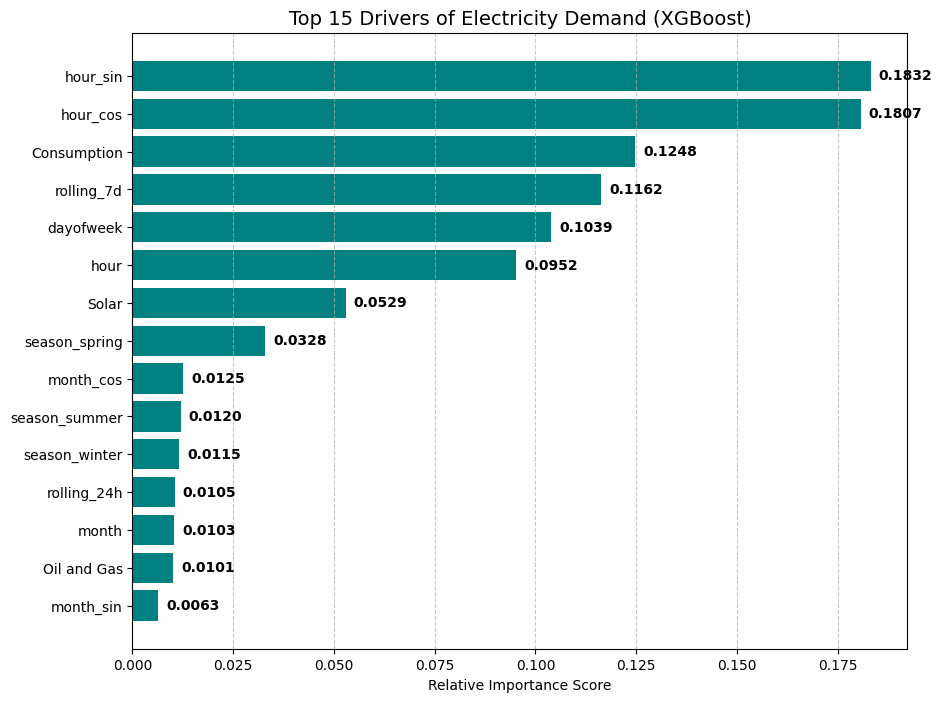

In [32]:
# ========================================================
# 9️⃣ FEATURE IMPORTANCE (Drivers of Electricity Demand)
# ========================================================
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor

# 1. Train the best XGBoost model on the most recent training split
# We use the best_params_xgb found in the tuning block
best_xgb_final = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)
best_xgb_final.fit(X_train, y_train)

# 2. Extract Importance
importances = best_xgb_final.feature_importances_
feature_names = X.columns
# Get the top 15 features
indices = np.argsort(importances)[-15:] 

# 3. Visualization
plt.figure(figsize=(10, 8))
plt.title('Top 15 Drivers of Electricity Demand (XGBoost)', fontsize=14)
bars = plt.barh(range(len(indices)), importances[indices], align='center', color='teal')

# Add data labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', va='center', fontweight='bold', fontsize=10)

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Save the plot for your report
plt.savefig(f'{OUTPUT_FOLDER}/05_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [33]:
# ========================================================
# 🔟 BIAS ANALYSIS (Model Reliability)
# ========================================================

# 1. Bias Analysis (Over vs Under Prediction)
bias_results = []

# We iterate through the predictions we saved in the Final Evaluation block
for model_name, (y_act, y_pre) in last_fold_predictions.items():
    # Convert to numpy for easy math; errors = (Forecast - Actual)
    # Positive error = Over-prediction | Negative error = Under-prediction
    errors = np.array(y_pre) - y_act.values
    
    bias_results.append({
        'Model': model_name,
        'Mean Bias (MW)': np.mean(errors),
        'Max Over-prediction': np.max(errors),
        'Max Under-prediction': np.min(errors)
    })

# 2. Format and Save
df_bias = pd.DataFrame(bias_results).round(2)
df_bias.to_csv(f'{OUTPUT_FOLDER}/06_bias_analysis.csv', index=False)

print("\n" + "="*45)
print("📊 BIAS ANALYSIS: RELIABILITY CHECK")
print("="*45)
display(df_bias)
print("="*45)
print("💡 Tip: Mean Bias near 0.00 is ideal.")
print("Positive = Over-predicting | Negative = Under-predicting")



📊 BIAS ANALYSIS: RELIABILITY CHECK


,Model,Mean Bias (MW),Max Over-prediction,Max Under-prediction
0,LinearRegression,25.37,2838.08,-2610.99
1,k-NN,152.80,3219.10,-2584.71
2,RandomForest,86.43,2578.74,-1524.59
3,HistGradientBoosting,58.14,2952.51,-1743.17
4,XGBoost,58.65,2806.85,-1766.76
5,LightGBM,57.56,2868.02,-1978.16


💡 Tip: Mean Bias near 0.00 is ideal.
Positive = Over-predicting | Negative = Under-predicting


In [37]:
# ========================================================
# 1️⃣1️⃣ OPERATIONAL IMPACT SUMMARY
# ========================================================

# 1. Identify Best Model and Persistence Baseline from the summary table
# We exclude 'Persistence' and 'SARIMA' to find the most robust ML winner
ml_models = summary[~summary['Model'].str.contains('Persistence|SARIMA', case=False)]
best_model_name = ml_models.iloc[0]['Model']
best_mae = ml_models.iloc[0]['MAE']

# Get Persistence MAE (The benchmark for "No Model" / Naive strategy)
persistence_mae = summary[summary['Model'].str.contains('Persistence')]['MAE'].values[0]

# 2. Operational Improvement Metrics
# We calculate how much "uncertainty" we remove compared to the naive baseline
mw_error_reduction = persistence_mae - best_mae
daily_mwh_uncertainty_removed = mw_error_reduction * 24
percentage_improvement = (mw_error_reduction / persistence_mae) * 100

# 3. Final Operational Dashboard
print(f"\n" + "="*45)
print(f"📊 OPERATIONAL IMPACT: {best_model_name.upper()}")
print("="*45)
print(f"Naive Baseline Error:     {persistence_mae:.2f} MW")
print(f"Optimized Model Error:    {best_mae:.2f} MW")
print(f"Precision Improvement:    {mw_error_reduction:.2f} MW (per hour)")
print("-" * 45)
print(f"SYSTEM RELIABILITY GAINS")
print(f"Accuracy Boost:           {percentage_improvement:.2f}%")
print(f"Daily Energy Uncertainty ")
print(f"Reduced by:               {daily_mwh_uncertainty_removed:.2f} MWh/day")
print("-" * 45)
print(f"Technical Insight: By utilizing {best_model_name}, the system")
print(f"reduces the 'prediction gap' significantly. This allows for")
print(f"better scheduling of base-load plants and reduces the")
print(f"need for emergency ramping of backup generators.")
print("="*45)


📊 OPERATIONAL IMPACT: XGBOOST
Naive Baseline Error:     921.30 MW
Optimized Model Error:    241.03 MW
Precision Improvement:    680.27 MW (per hour)
---------------------------------------------
SYSTEM RELIABILITY GAINS
Accuracy Boost:           73.84%
Daily Energy Uncertainty 
Reduced by:               16326.40 MWh/day
---------------------------------------------
Technical Insight: By utilizing XGBoost, the system
reduces the 'prediction gap' significantly. This allows for
better scheduling of base-load plants and reduces the
need for emergency ramping of backup generators.


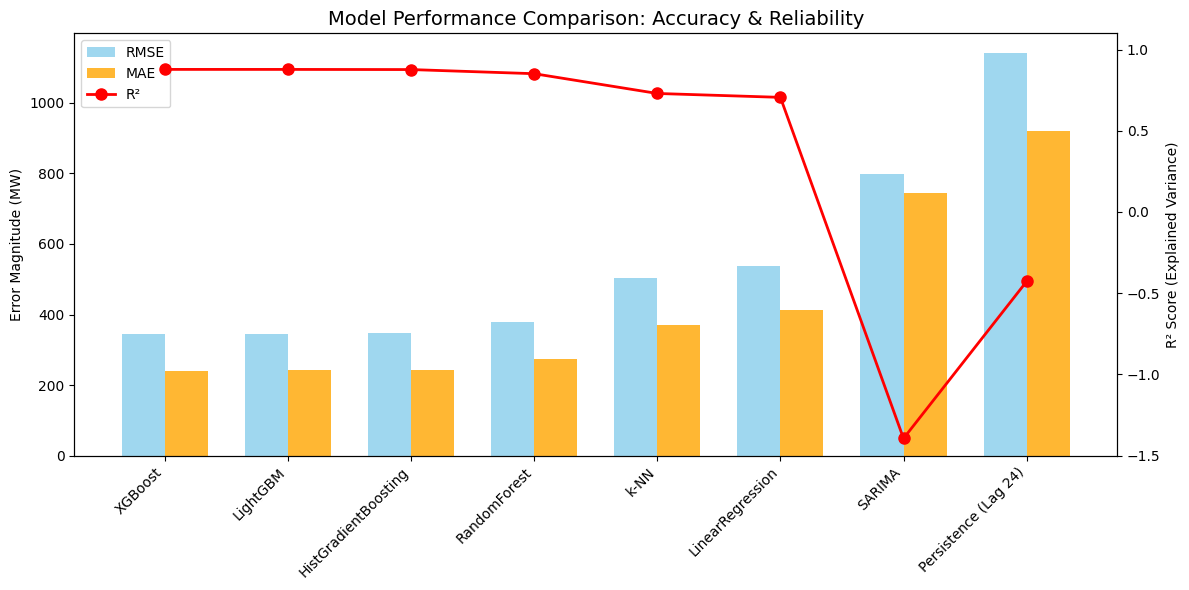

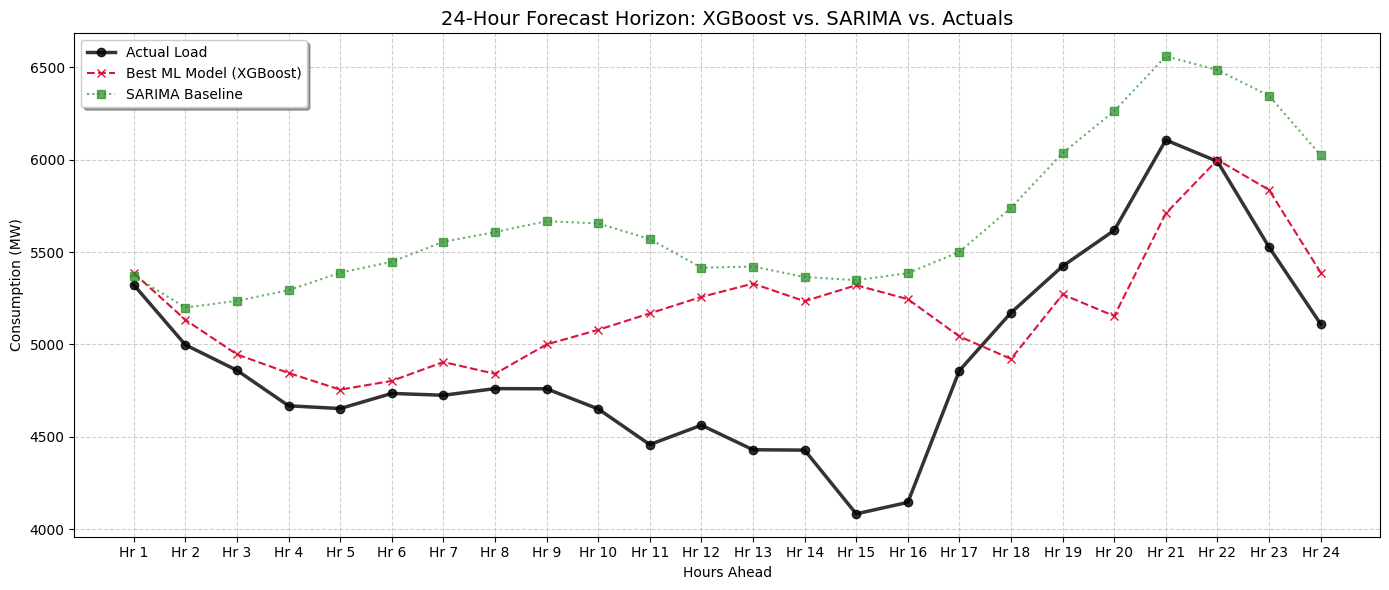

✅ Success! All final charts saved in: ../outputs


In [36]:
# ========================================================
# 1️⃣2️⃣ FINAL COMPARISON CHART + PREDICTED VS ACTUAL
# ========================================================

import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure the output directory exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 1. Comparison Chart (Leaderboard)
x = np.arange(len(summary))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars for Error Metrics
ax1.bar(x - width/2, summary['RMSE'], width, label='RMSE', color='skyblue', alpha=0.8)
ax1.bar(x + width/2, summary['MAE'], width, label='MAE', color='orange', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(summary['Model'], rotation=45, ha='right')
ax1.set_ylabel('Error Magnitude (MW)')
ax1.set_title('Model Performance Comparison: Accuracy & Reliability', fontsize=14)

# Line for R² on a secondary axis
ax2 = ax1.twinx()
ax2.plot(x, summary['R2'], marker='o', linewidth=2, label='R²', color='red', markersize=8)
ax2.set_ylabel('R² Score (Explained Variance)')
ax2.set_ylim(-1.5, 1.1)

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/07_performance_leaderboard.png', dpi=300)
plt.show()

# 2. Predicted vs Actual (The "Hero" Plot)
# We will compare the BEST ML Model against SARIMA and Actuals
ml_winners = summary[~summary['Model'].str.contains('Persistence|SARIMA', case=False)]
best_model_name = ml_winners.iloc[0]['Model']

plt.figure(figsize=(14, 6))

# A. Extract Actuals and ML Predictions (Last 24-hour window)
y_act_df, y_pre_matrix = last_fold_predictions[best_model_name]
y_actual = y_act_df.iloc[-1].values 
y_pred_ml = y_pre_matrix[-1]
index = [f"Hr {i}" for i in range(1, 25)]

# B. Plotting
plt.plot(index, y_actual, label='Actual Load', color='black', linewidth=2.5, marker='o', alpha=0.8)
plt.plot(index, y_pred_ml, label=f'Best ML Model ({best_model_name})', linestyle='--', marker='x', color='crimson')

# C. Add SARIMA if it exists
try:
    plt.plot(index, sarima_pred.values, label='SARIMA Baseline', linestyle=':', marker='s', color='forestgreen', alpha=0.7)
except NameError:
    print("SARIMA not found for combined plot.")

plt.title(f'24-Hour Forecast Horizon: {best_model_name} vs. SARIMA vs. Actuals', fontsize=14)
plt.xlabel('Hours Ahead')
plt.ylabel('Consumption (MW)')
plt.legend(frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig(f'{OUTPUT_FOLDER}/08_final_forecast_comparison.png', dpi=300)
plt.show()

print(f"✅ Success! All final charts saved in: {OUTPUT_FOLDER}")
